In [1]:
! pip install category_encoders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, f_oneway, ttest_ind, kstest, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, roc_auc_score, RocCurveDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, roc_curve, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.8 MB/s eta 0:00:00


In [2]:
df = pd.read_csv('ola_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,MMM-YY,Driver_ID,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
0,0,1/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,2381060,2
1,1,2/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,NaN,1,1,-665480,2
2,2,3/1/2019,1,28.0,0.0,C23,2,57387,24/12/18,3/11/2019,1,1,0,2
3,3,11/1/2020,2,31.0,0.0,C7,2,67016,11/6/2020,NaN,2,2,0,1
4,4,12/1/2020,2,31.0,0.0,C7,2,67016,11/6/2020,NaN,2,2,0,1


## `Making sure that any column with string values have no leading or trailing whitespaces`

In [4]:
for col in df.columns:
  if df[col].dtype == 'str' or df[col].dtype == 'object':
    df[col] = df[col].str.strip()

***

# `Data dictionary:`
#### `1.	MMMM-YY :` Reporting Date (Monthly)
#### `2.	Driver_ID :` Unique id for drivers
#### `3.	Age :` Age of the driver
#### `4.	Gender :` Gender of the driver – Male : 0, Female: 1
#### `5.	City :` City Code of the driver
#### `6.	Education_Level :` Education level – 0 for 10+, 1 for 12+, 2 for graduate
#### `7.	Income :` Monthly average Income of the driver
#### `8.	Date Of Joining :` Joining date for the driver
#### `9.	LastWorkingDate :` Last date of working for the driver
#### `10.	Joining Designation :` Designation of the driver at the time of joining
#### `11.	Grade :` Grade of the driver at the time of reporting
#### `12.	Total Business Value :` The total business value acquired by the driver in a month (negative business indicates cancellation/refund or car EMI adjustments)
#### `13.	Quarterly Rating :` Quarterly rating of the driver: 1,2,3,4,5 (higher is better)


***

# **`Problem statement:`**

### Recruiting and retaining drivers is seen by industry watchers as a tough battle for Ola. Churn among drivers is high and it's very easy for drivers to stop working for the service on the fly or jump to Uber depending on the rates.
### As the companies get bigger, the high churn could become a bigger problem. To find new drivers, Ola is casting a wide net, including people who don't have cars for jobs. But this acquisition is really costly. Losing drivers frequently impacts the morale of the organization and acquiring new drivers is more expensive than retaining existing ones.
### You are working as a data scientist with the Analytics Department of Ola, focused on driver team attrition. You are provided with the monthly information for a segment of drivers for 2019 and 2020 and tasked to predict whether a driver will be leaving the company or not based on their attributes like
### •	Demographics (city, age, gender etc.)

### •	Tenure information (joining date, Last Date)

### •	Historical data regarding the performance of the driver (Quarterly rating, Monthly business acquired, grade, Income)


***

# **`Data types of the variables:`**

### `1. MMM-YY:` object (Independent Variable or Feature)
### `2. Driver_ID:` int64 (Independent Variable or Feature). As it is a nominal categorical feature, we'll transform it into category data type.
### `3. Age:` float64 (Independent Variable or Feature)
### `4. Gender:` float64 (Independent Variable or Feature). As it is a nominal categorical feature, we'll transform it into category data type.
### `5. City:` object (Independent Variable or Feature)
### `6. Education_Level:` int64 (Independent Variable or Feature)
### `7. Income:` int64 (Independent Variable or Feature)
### `8. Dateofjoining:` object (Independent Variable or Feature)
### `9. LastWorkingDate:` object (Independent Variable or Feature)
### `10. Joining Designation:` int64 (Independent Variable or Feature).
### `11. Grade:` int64 (Independent Variable or Feature)
### `12. Total Business Value:` int64 (Independent Variable or Feature)
### `13. Quarterly Rating:` int64 (Independent Variable or Feature)



In [5]:
df.dtypes

Unnamed: 0                int64
MMM-YY                   object
Driver_ID                 int64
Age                     float64
Gender                  float64
City                     object
Education_Level           int64
Income                    int64
Dateofjoining            object
LastWorkingDate          object
Joining Designation       int64
Grade                     int64
Total Business Value      int64
Quarterly Rating          int64
dtype: object

***

# `Missing Value Detection:`
### `1. Age:` There are 61 missing values in the `Age` column which is only 61/19104 i.e. **`0.3%.`**
### `2. Gender:` There are 52 missing values in the `Gender` column which is only 52/19104 i.e. **`0.2%.`**
### `3. LastWorkingDate:` There are 17488 missing values in the `LastWorkingDate` column. Missing value in `LastWorkingDate` only suggests that the driver has not left and is still with Ola.

In [6]:
df.isnull().sum()

Unnamed: 0                  0
MMM-YY                      0
Driver_ID                   0
Age                        61
Gender                     52
City                        0
Education_Level             0
Income                      0
Dateofjoining               0
LastWorkingDate         17488
Joining Designation         0
Grade                       0
Total Business Value        0
Quarterly Rating            0
dtype: int64

***

# **`Statistical Summary`**

### `1. Age:` Minimum age is 21, 25th percentile value is 30, median age is 34, 75th percentile value is 39 and maximum age is 58. From these values, it looks like age distribution is a little right-skewed i.e. there are few drivers who have high age.

### `2. Gender:` 11074 out of 19104 (~58%) drivers are male.

### `3. City:` 1008 out of 19104 (~5%) drivers are from city code C20.

### `4. Education_Level:` 6864 out of 19104 (~36%) drivers possess education level = 1 i.e. 12+.

### `5. Income:` Minimum Income is 10747, 25th percentile value is 42383, median Income is 60087, 75th percentile value is 83969 and maximum Income is 188418. From these values, it looks like Income distribution is right-skewed i.e. there are few drivers who have very high income.

### `6. Joining Designation:` 9381 out of 19104 (~49%) drivers joined at designation = 1.

### `7. Grade:` 6627 out of 19104 (~35%) drivers have garde = 2.

### `8. Total Business Value:` Minimum Total Business Value is -6 Mn, 25th percentile value is 0, median Total Business Value is 250000, 75th percentile value is 699700 and maximum Total Business Value is 33747720. From these values, it looks like Total Business Value distribution is right-skewed i.e. there are few drivers who have very high Total Business Value.

### `9. Quarterly Rating:` Minimum Quarterly Rating is 1, 25th percentile value is 1, median Quarterly Rating is 2, 75th percentile value is 3 and maximum Quarterly Rating is 4.

In [7]:
def clean_str_cols(col):
  if col.dtype == 'object' or col.dtype == 'str':
    return col.str.replace('.0', '', regex = False)
  else:
    return col

In [8]:
df.astype({'Gender': 'str', 'Education_Level': 'str',
           'Joining Designation': 'str', 'Grade': 'str'}).drop(columns = ['Driver_ID', 'MMM-YY']).apply(lambda x: clean_str_cols(x)).describe(include = 'all')

,Unnamed: 0,Age,Gender,City,Education_Level,Income,Dateofjoining,LastWorkingDate,Joining Designation,Grade,Total Business Value,Quarterly Rating
count,19104.000000,19043.000000,19104,19104,19104,19104.000000,19104,1616,19104,19104,1.910400e+04,19104.000000
unique,NaN,NaN,3,29,3,NaN,869,493,5,5,NaN,NaN
top,NaN,NaN,0,C20,1,NaN,23/07/15,29/07/20,1,2,NaN,NaN
freq,NaN,NaN,11074,1008,6864,NaN,192,70,9831,6627,NaN,NaN
mean,9551.500000,34.668435,NaN,NaN,NaN,65652.025126,NaN,NaN,NaN,NaN,5.716621e+05,2.008899
std,5514.994107,6.257912,NaN,NaN,NaN,30914.515344,NaN,NaN,NaN,NaN,1.128312e+06,1.009832
min,0.000000,21.000000,NaN,NaN,NaN,10747.000000,NaN,NaN,NaN,NaN,-6.000000e+06,1.000000
25%,4775.750000,30.000000,NaN,NaN,NaN,42383.000000,NaN,NaN,NaN,NaN,0.000000e+00,1.000000
50%,9551.500000,34.000000,NaN,NaN,NaN,60087.000000,NaN,NaN,NaN,NaN,2.500000e+05,2.000000
75%,14327.250000,39.000000,NaN,NaN,NaN,83969.000000,NaN,NaN,NaN,NaN,6.997000e+05,3.000000


***

# **`Data Type Conversion`**

## **`Converting columns MMM-YY, Dateofjoining & LastWorkingDate to datetime`**

In [9]:
df['MMM-YY'] = df['MMM-YY'].astype('datetime64[s]')
df[['Dateofjoining', 'LastWorkingDate']] = df[['Dateofjoining', 'LastWorkingDate']].astype('datetime64[s]')

***

# **`Univariate Analysis`**

In [10]:
total_size = df.shape[0]

## **`1. Year:`** As we can see that there is an almost even split between 2019 & 2020.

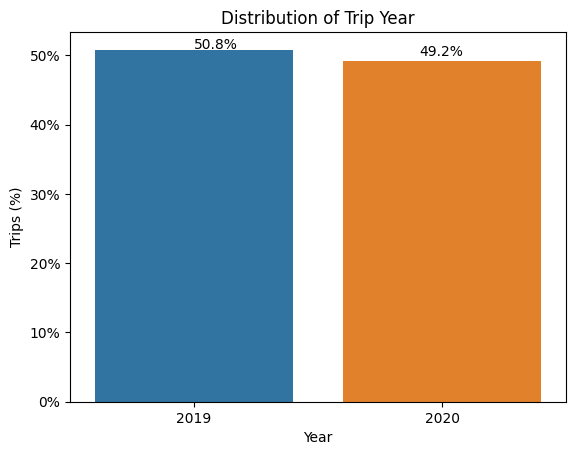

In [11]:
ax = sns.barplot(x = df['MMM-YY'].dt.year.astype('str').value_counts().index, y = df['MMM-YY'].dt.year.astype('str').value_counts(normalize = True).values * 100)
ax.annotate(f"{(df['MMM-YY'].dt.year.astype('str').value_counts(normalize = True).values.round(3) * 100)[0]}%", (1e-3, 51))
ax.annotate(f"{(df['MMM-YY'].dt.year.astype('str').value_counts(normalize = True).values.round(3) * 100)[1]}%", (0.91, 50))
plt.yticks(ticks = range(0, 60, 10), labels = [str(i) + '%' for i in range(0, 60, 10)])
plt.xlabel('Year')
plt.ylabel('Trips (%)')
plt.title('Distribution of Trip Year')
plt.show()

## **`2. Age:`** We can clearly notice from the distribution (shown below) that the drivers' age is almost symmetrically distributed with a little right skew and median age = 34.

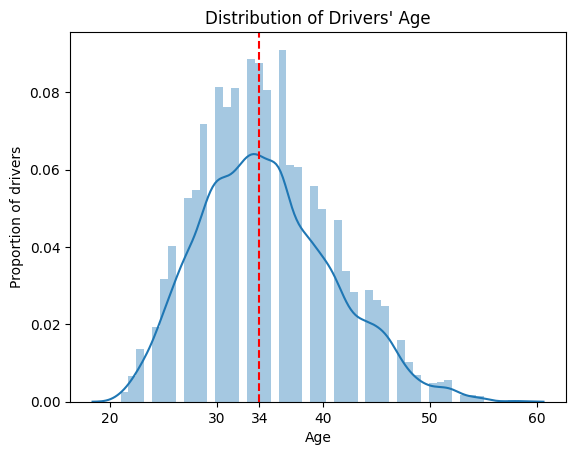

In [12]:
sns.distplot(df['Age'])
plt.axvline(df['Age'].median(), color = 'r', linestyle = '--')
plt.ylabel('Proportion of drivers')
plt.xticks(ticks = list(range(20, 70, 10)) + [df['Age'].median()])
plt.title("Distribution of Drivers' Age")
plt.show()

In [13]:
df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female').value_counts(normalize = True).values.round(3) * 100

array([58., 42.])

## **`3. Gender:`** We can clearly see from the distribution (shown below) that 58% of tghe drivers are Male and remaining 42% are females.

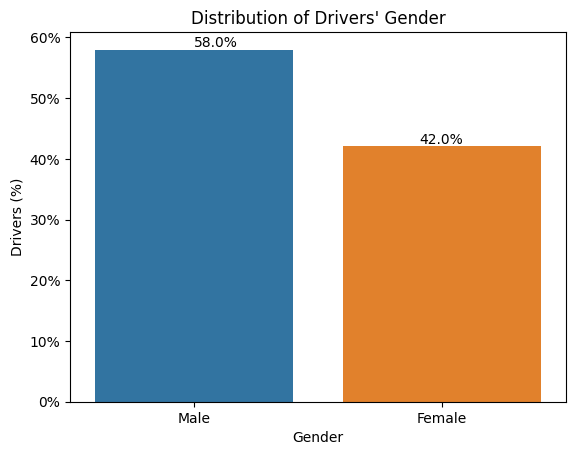

In [14]:
ax = sns.barplot(x = df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female').value_counts().index, y = df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female').value_counts(normalize = True).values * 100)
ax.annotate(f"{(df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female').value_counts(normalize = True).values.round(3) * 100)[0].round(1)}%", (1e-3, 58.5))
ax.annotate(f"{(df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female').value_counts(normalize = True).values.round(3) * 100)[1].round(1)}%", (0.91, 42.5))
plt.yticks(ticks = range(0, 70, 10), labels = [str(i) + '%' for i in range(0, 70, 10)])
plt.xlabel('Gender')
plt.ylabel('Drivers (%)')
plt.title("Distribution of Drivers' Gender")
plt.show()

# **`4. City`**

Text(0, 0.5, "Drivers' (%)")

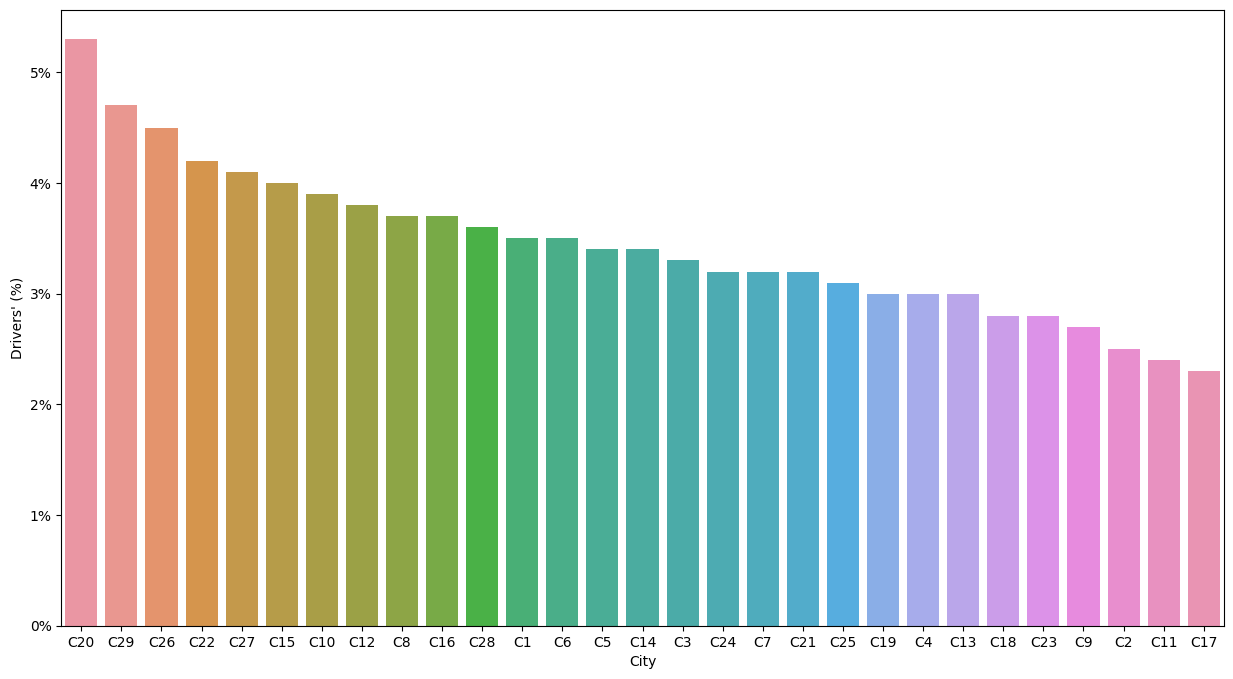

In [15]:
plt.figure(figsize = (15, 8))
sns.barplot(x = df['City'].value_counts().index, y = df['City'].value_counts(normalize = True).values.round(3) * 100)
plt.yticks(ticks = range(0, 6), labels = [str(i) + '%' for i in range(0, 6)])
plt.xlabel('City')
plt.ylabel("Drivers' (%)")

## **`5. Education Level:`** Drivers are almost identically distributed w.r.t. education across 10+, 12+ and Graduate.

Text(0, 0.5, "Drivers' (%)")

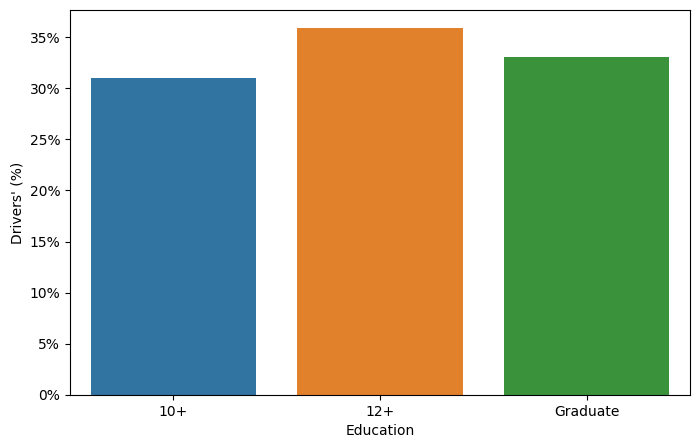

In [16]:
plt.figure(figsize = (8, 5))
sns.barplot(x = df['Education_Level'].value_counts().index, y = df['Education_Level'].value_counts(normalize = True).values.round(3) * 100)
plt.yticks(ticks = range(0, 40, 5), labels = [str(i) + '%' for i in range(0, 40, 5)])
plt.xticks(ticks = range(0, 3), labels = ['10+', '12+', 'Graduate'])
plt.xlabel('Education')
plt.ylabel("Drivers' (%)")

## **`6. Income:`** We can clearly notice from the distribution (shown below) that the drivers' age is right skewed with a median income of ~60000.

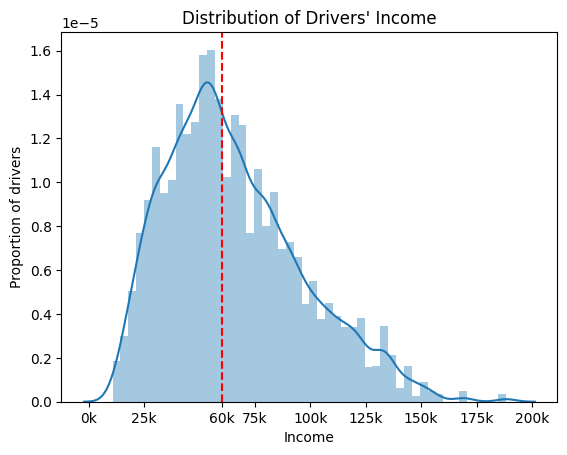

In [17]:
sns.distplot(df['Income'])
plt.axvline(df['Income'].median(), color = 'r', linestyle = '--')
plt.ylabel('Proportion of drivers')
plt.xticks(ticks = list(range(0, 50000, 25000)) + list(range(75000, 225000, 25000)) + [df['Income'].median()], labels = [str(i) + 'k' for i in range(0, 50, 25)] + [str(i) + 'k' for i in range(75, 225, 25)] + [f"{round(df['Income'].median()/1000)}k"])
plt.title("Distribution of Drivers' Income")
plt.show()

## **`7. Year of Joining:`** More than 65 % of the drivers joined after 2017

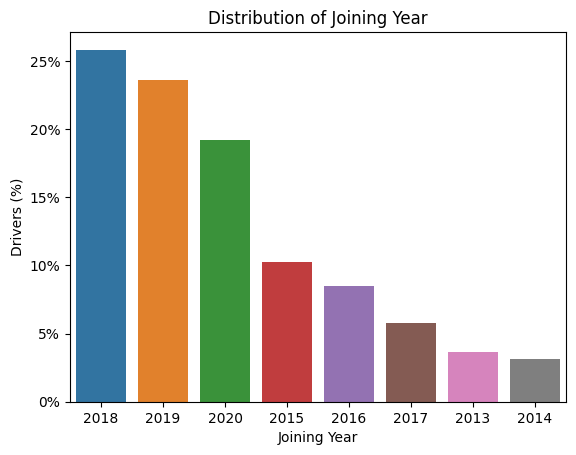

In [18]:
ax = sns.barplot(x = df['Dateofjoining'].dt.year.astype('str').value_counts().index, y = df['Dateofjoining'].dt.year.astype('str').value_counts(normalize = True).values * 100)
ax.annotate(f"{(df['Dateofjoining'].dt.year.astype('str').value_counts(normalize = True).values.round(3) * 100)[0]}%", (1e-3, 51))
ax.annotate(f"{(df['Dateofjoining'].dt.year.astype('str').value_counts(normalize = True).values.round(3) * 100)[1]}%", (0.91, 50))
plt.yticks(ticks = range(0, 30, 5), labels = [str(i) + '%' for i in range(0, 30, 5)])
plt.xlabel('Joining Year')
plt.ylabel('Drivers (%)')
plt.title('Distribution of Joining Year')
plt.show()

## **`8. Month of Joining:`** Most the drivers join after 1st quarter of the year

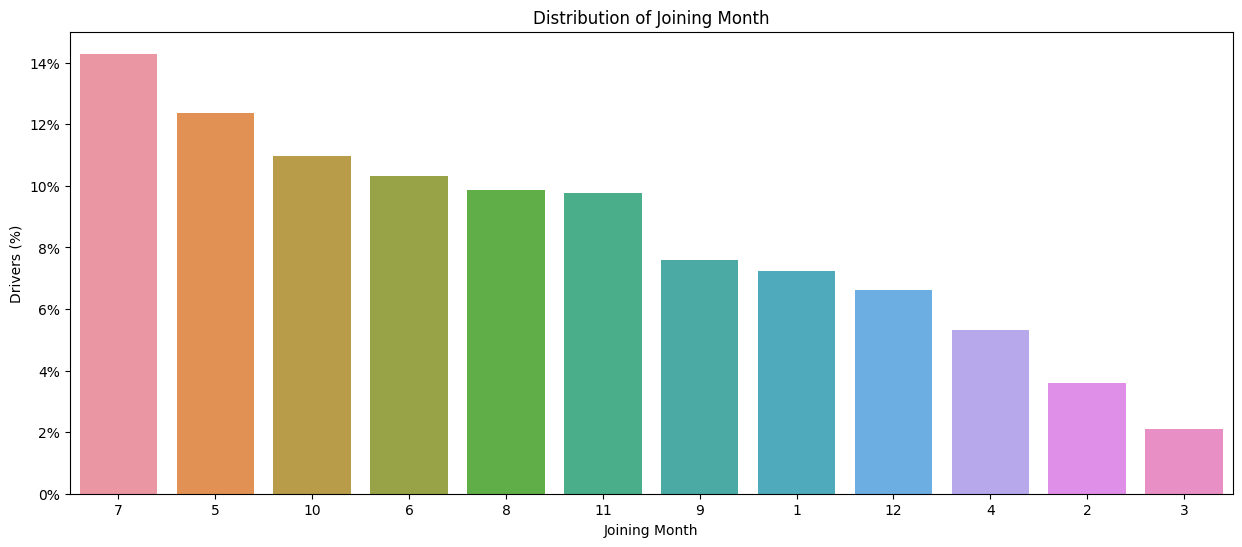

In [19]:
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = df['Dateofjoining'].dt.month.astype('str').value_counts().index, y = df['Dateofjoining'].dt.month.astype('str').value_counts(normalize = True).values * 100)
ax.annotate(f"{(df['Dateofjoining'].dt.month.astype('str').value_counts(normalize = True).values.round(3) * 100)[0]}%", (1e-3, 51))
ax.annotate(f"{(df['Dateofjoining'].dt.month.astype('str').value_counts(normalize = True).values.round(3) * 100)[1]}%", (0.91, 50))
plt.yticks(ticks = range(0, 16, 2), labels = [str(i) + '%' for i in range(0, 16, 2)])
plt.xlabel('Joining Month')
plt.ylabel('Drivers (%)')
plt.title('Distribution of Joining Month')
plt.show()

## **`9. Year of Last Working Day:`** Out of all the drivers who left Ola, ~50% left in 2019 & remianing ~50% in 2020.

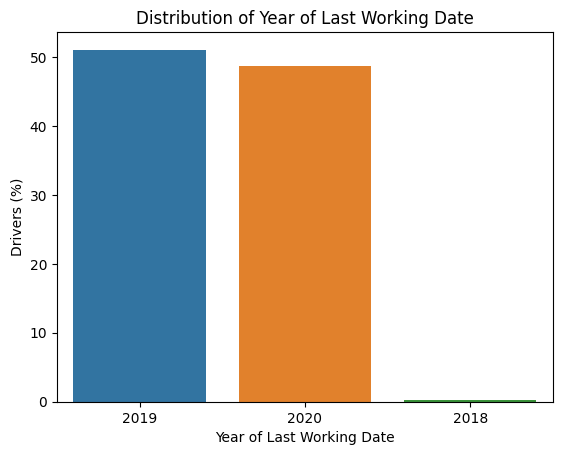

In [20]:
ax = sns.barplot(x = df['LastWorkingDate'].dropna().dt.year.astype('str').value_counts().index, y = df['LastWorkingDate'].dropna().dt.year.astype('str').value_counts(normalize = True).values * 100)
plt.xlabel('Year of Last Working Date')
plt.ylabel('Drivers (%)')
plt.title('Distribution of Year of Last Working Date')
plt.show()

## **`10. Month of Last Working Day:`** Out of all the drivers who left Ola, more than 30% left in February, May & July.

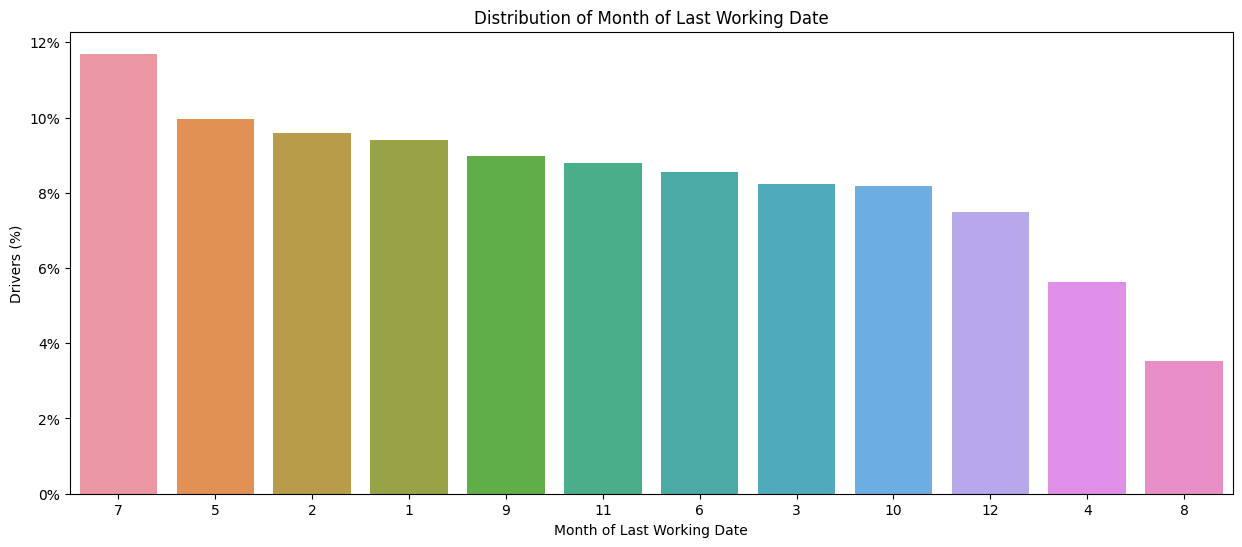

In [21]:
plt.figure(figsize = (15, 6))
ax = sns.barplot(x = df['LastWorkingDate'].dropna().dt.month.astype('str').value_counts().index, y = df['LastWorkingDate'].dropna().dt.month.astype('str').value_counts(normalize = True).values * 100)
ax.annotate(f"{(df['LastWorkingDate'].dropna().dt.month.astype('str').value_counts(normalize = True).values.round(3) * 100)[0]}%", (1e-3, 51))
ax.annotate(f"{(df['LastWorkingDate'].dropna().dt.month.astype('str').value_counts(normalize = True).values.round(3) * 100)[1]}%", (0.91, 50))
plt.yticks(ticks = range(0, 14, 2), labels = [str(i) + '%' for i in range(0, 14, 2)])
plt.xlabel('Month of Last Working Date')
plt.ylabel('Drivers (%)')
plt.title('Distribution of Month of Last Working Date')
plt.show()

## **`11. Joining Designation:`** More than 80% of the driver joined at designation of either 1 or 2.

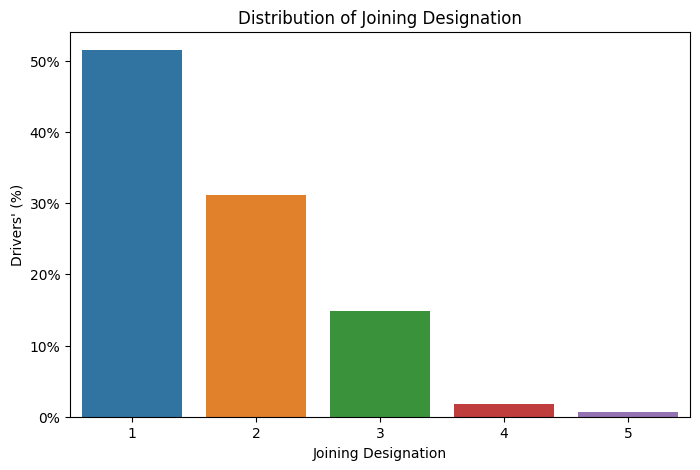

In [22]:
plt.figure(figsize = (8, 5))
sns.barplot(x = df['Joining Designation'].value_counts().index, y = df['Joining Designation'].value_counts(normalize = True).values.round(3) * 100)
plt.yticks(ticks = range(0, 60, 10), labels = [str(i) + '%' for i in range(0, 60, 10)])
plt.xlabel('Joining Designation')
plt.ylabel("Drivers' (%)")
plt.title('Distribution of Joining Designation')
plt.show()

## **`12. Grade:`** More than 85% of the driver joined Ola at Grade of either 1, 2 or 3.

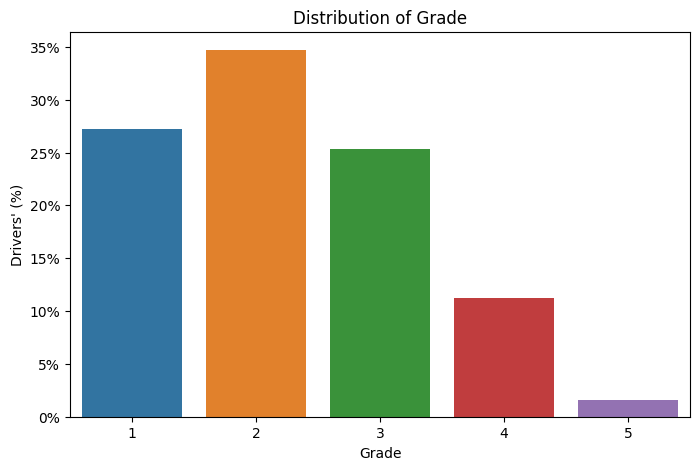

In [23]:
plt.figure(figsize = (8, 5))
sns.barplot(x = df['Grade'].value_counts().index, y = df['Grade'].value_counts(normalize = True).values.round(3) * 100)
plt.yticks(ticks = range(0, 40, 5), labels = [str(i) + '%' for i in range(0, 40, 5)])
plt.xlabel('Grade')
plt.ylabel("Drivers' (%)")
plt.title('Distribution of Grade')
plt.show()

## **`13. Total Business Value:`** We can notice from the distribution (shown below) that the drivers' Total Business Value is right skewed suggesting that some drivers have very high Total Business Value.

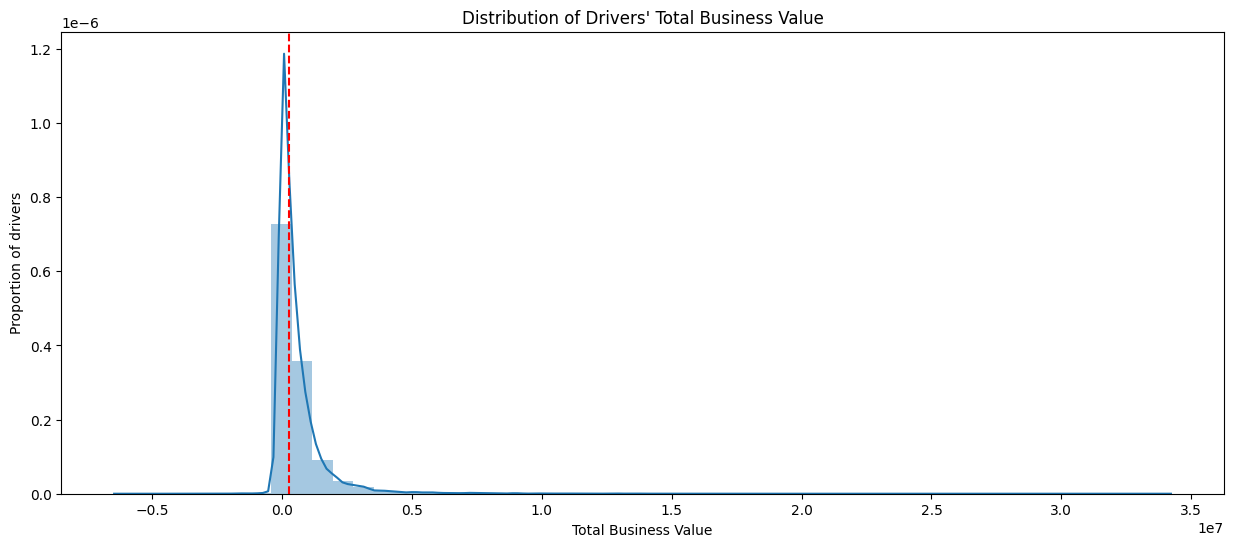

In [24]:
plt.figure(figsize = (15, 6))
sns.distplot(df['Total Business Value'])
plt.axvline(df['Total Business Value'].median(), color = 'r', linestyle = '--')
plt.ylabel('Proportion of drivers')
plt.title("Distribution of Drivers' Total Business Value")
plt.show()

## **`14. Quarterly Rating:`** ~70% of the drivers have Quarterly Rating either equal to 1 or 2.

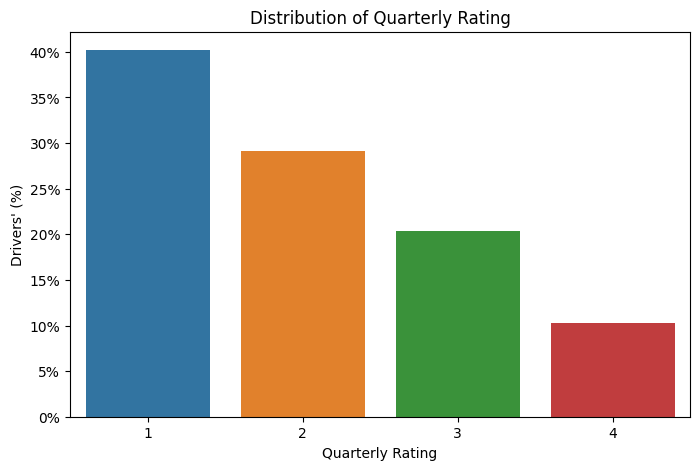

In [25]:
plt.figure(figsize = (8, 5))
sns.barplot(x = df['Quarterly Rating'].value_counts().index, y = df['Quarterly Rating'].value_counts(normalize = True).values.round(3) * 100)
plt.yticks(ticks = range(0, 45, 5), labels = [str(i) + '%' for i in range(0, 45, 5)])
plt.xlabel('Quarterly Rating')
plt.ylabel("Drivers' (%)")
plt.title('Distribution of Quarterly Rating')
plt.show()

***

# **`Bivariate Analysis`**

## **`1. Age Vs Percent of employee left:`** Young employees i.e. having age between 21 & 30 years tend to leave more.

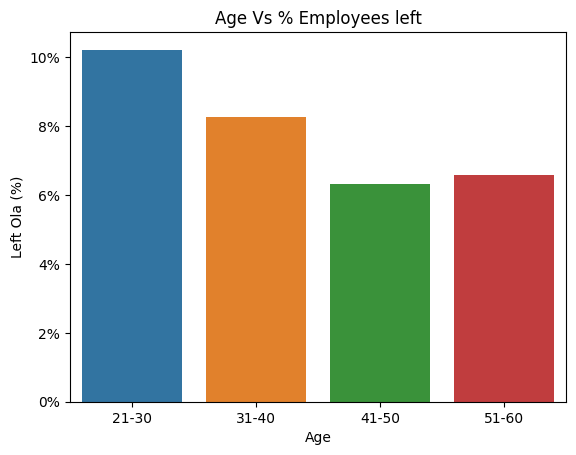

In [26]:
df['left'] = (~df['LastWorkingDate'].isnull()).astype('int64')
df['age_cat'] = df['Age'].apply(lambda x: '21-30' if 21 <= x <= 30 else '31-40' if 31 <= x <= 40
                                else '41-50' if 41 <= x <= 50 else '51-60')
age_vs_left = df.groupby('age_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = age_vs_left['age_cat'], y = age_vs_left['left'] * 100)
plt.xlabel('Age')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 12, 2), labels = [str(i) + '%' for i in range(0, 12, 2)])
plt.title('Age Vs % Employees left')
plt.show()
df.drop(columns = 'age_cat', inplace = True)

## **`2. Gender Vs Percent of employee left:`** Attrition Rate of Male & Female Employees is almost the same.

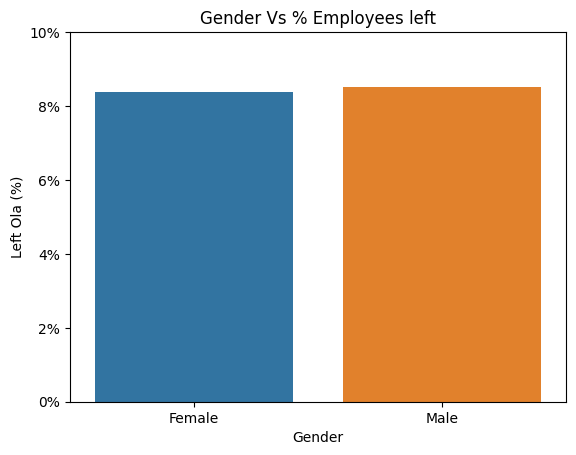

In [27]:
df['Gender_2'] = df['Gender'].apply(lambda x: 'Male' if x == 0 else 'Female')
gender_vs_left = df.groupby('Gender_2')['left'].mean().to_frame().reset_index()

sns.barplot(x = gender_vs_left['Gender_2'], y = gender_vs_left['left'] * 100)
plt.xlabel('Gender')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 12, 2), labels = [str(i) + '%' for i in range(0, 12, 2)])
plt.title('Gender Vs % Employees left')
plt.show()
df.drop(columns = 'Gender_2', inplace = True)

## **`3. City Vs Percent of employee left:`** The pattern of drivers leaving Ola is more or less same across all the cities.

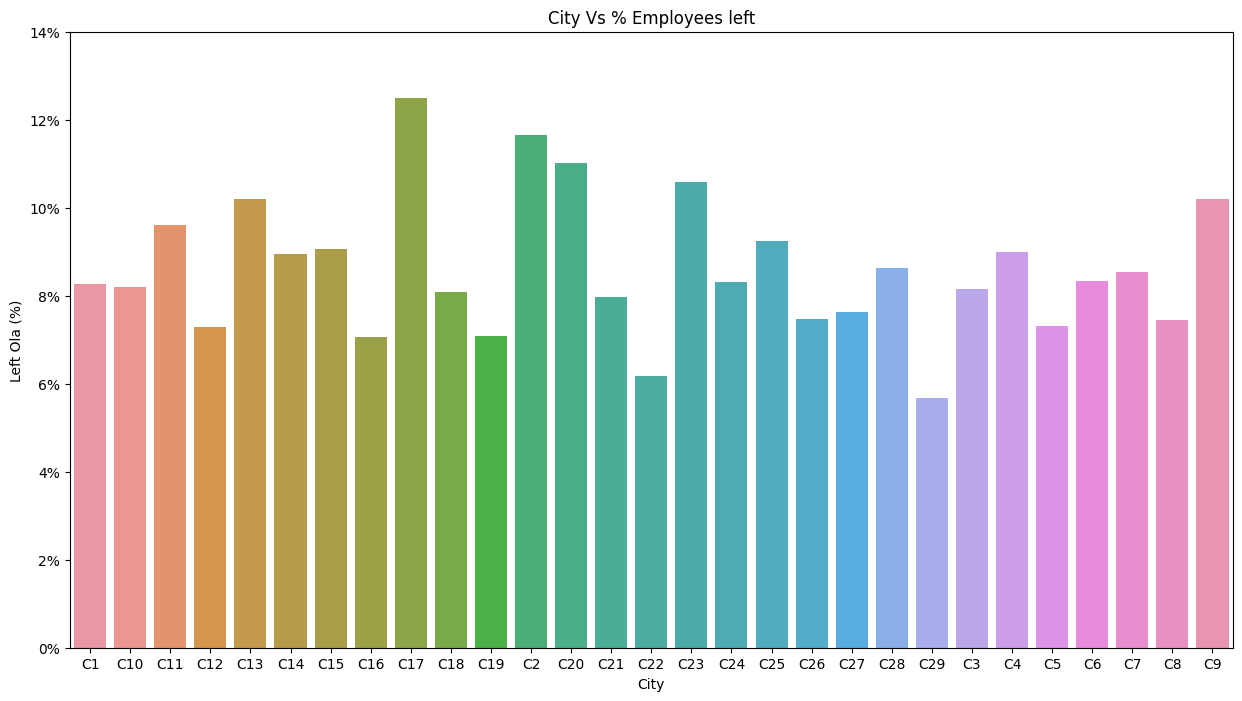

In [28]:
plt.figure(figsize = (15, 8))
city_vs_left = df.groupby('City')['left'].mean().to_frame().reset_index()
sns.barplot(x = city_vs_left['City'], y = city_vs_left['left'] * 100)
plt.xlabel('City')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 16, 2), labels = [str(i) + '%' for i in range(0, 16, 2)])
plt.title('City Vs % Employees left')
plt.show()

## **`4. Education_Level Vs Percent of employee left:`** The Attrition Rate is same across the drivers of all different education levels.

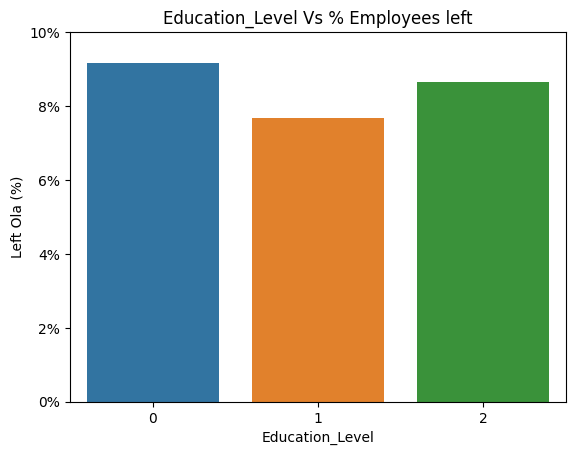

In [29]:
edu_vs_left = df.groupby('Education_Level')['left'].mean().to_frame().reset_index()
sns.barplot(x = edu_vs_left['Education_Level'], y = edu_vs_left['left'] * 100)
plt.xlabel('Education_Level')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 12, 2), labels = [str(i) + '%' for i in range(0, 12, 2)])
plt.title('Education_Level Vs % Employees left')
plt.show()

## **`5. Income Vs Percent of employee left:`** Attrition rate of drivers is inversely proportional to their income i.e. high income drivers tend to leave less and vice-versa.

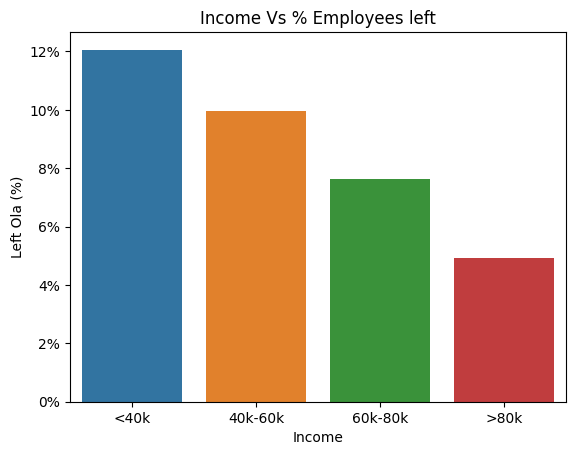

In [30]:
df['Income'].min(), np.percentile(df['Income'], [25, 50, 75]), df['Income'].max()
df['income_cat'] = df['Income'].apply(lambda x: '<40k' if 10000 <= x <= 40000 else '40k-60k' if 40001 <= x <= 60000
                                else '60k-80k' if 60001 <= x <= 80000 else '>80k')
inc_vs_left = df.groupby('income_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = inc_vs_left['income_cat'], y = inc_vs_left['left'] * 100, order = ['<40k', '40k-60k', '60k-80k', '>80k'])
plt.xlabel('Income')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 14, 2), labels = [str(i) + '%' for i in range(0, 14, 2)])
plt.title('Income Vs % Employees left')
plt.show()

## **`6. Joining Designation Vs Percent of employee left:`** Drivers with Joining Designation either 2 or 3 seems to leave more as compared to the drivers having other Joining Designation

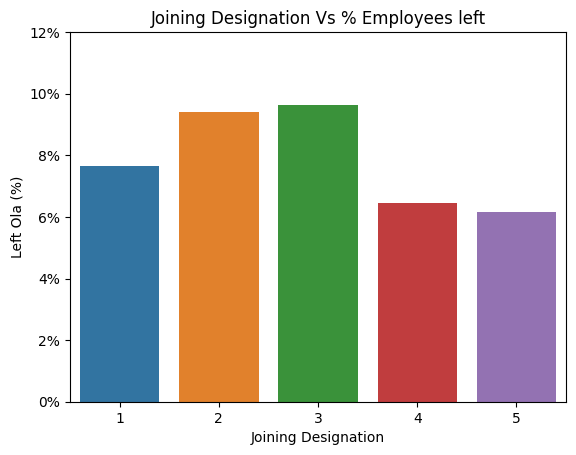

In [31]:
designation_vs_left = df.groupby('Joining Designation')['left'].mean().to_frame().reset_index()
sns.barplot(x = designation_vs_left['Joining Designation'], y = designation_vs_left['left'] * 100)
plt.xlabel('Joining Designation')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 14, 2), labels = [str(i) + '%' for i in range(0, 14, 2)])
plt.title('Joining Designation Vs % Employees left')
plt.show()

## **`7. Grade Vs Percent of employee left:`** Drivers with lower grades seems to leave more as compared to the drivers having higher grades.

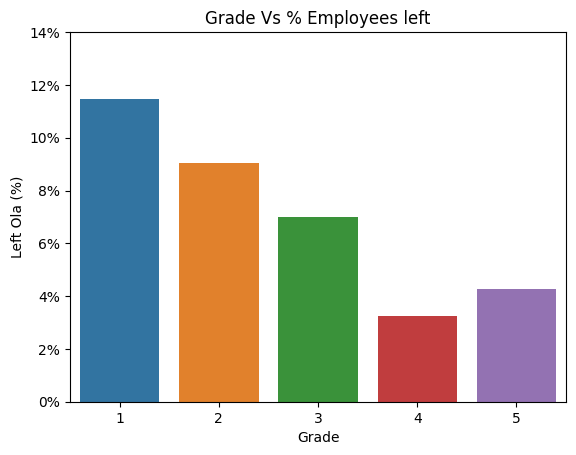

In [32]:
grade_vs_left = df.groupby('Grade')['left'].mean().to_frame().reset_index()
sns.barplot(x = grade_vs_left['Grade'], y = grade_vs_left['left'] * 100)
plt.xlabel('Grade')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 16, 2), labels = [str(i) + '%' for i in range(0, 16, 2)])
plt.title('Grade Vs % Employees left')
plt.show()

## **`8. Grade Vs Income:`** There is a positive correlation of income with grade i.e. high grade drivers have income higher than those with lower grades.

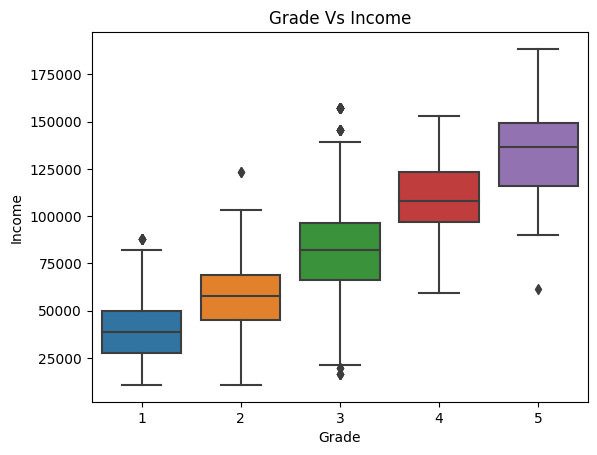

In [33]:
sns.boxplot(x = df['Grade'], y = df['Income'])
plt.xlabel('Grade')
plt.ylabel('Income')
plt.title('Grade Vs Income')
plt.show()

## **`9. Joining Designation Vs Income:`** There is a positive correlation of income with Joining Designation i.e. high Joining Designation drivers have income higher than those with lower Joining Designation.

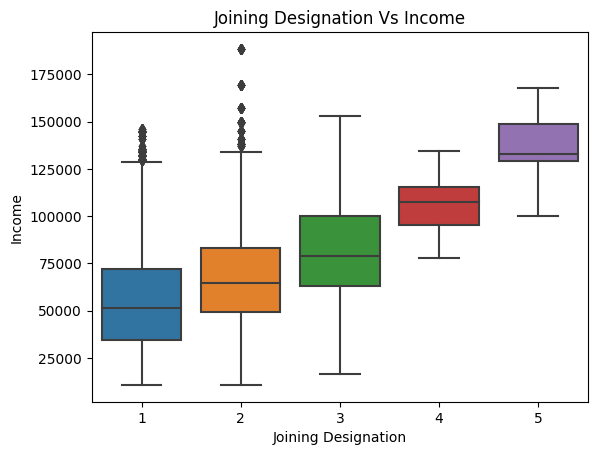

In [34]:
sns.boxplot(x = df['Joining Designation'], y = df['Income'])
plt.xlabel('Joining Designation')
plt.ylabel('Income')
plt.title('Joining Designation Vs Income')
plt.show()

## **`10.Gender Vs Income:`** The income of Male & Female Drivers is similar except a few male outliers who have very high income.

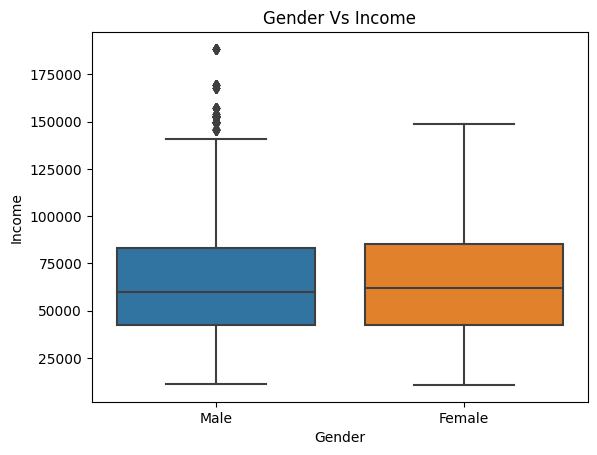

In [35]:
sns.boxplot(x = df['Gender'], y = df['Income'])
plt.xticks(ticks = [0, 1], labels = ['Male', 'Female'])
plt.xlabel('Gender')
plt.ylabel('Income')
plt.title('Gender Vs Income')
plt.show()

## **`11.Education_Level Vs Income:`** The income of drivers is similar across all the education levels except a few graduate outliers who have very high income.

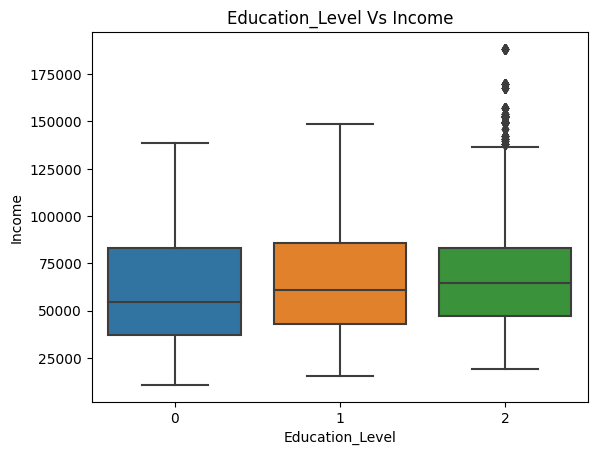

In [36]:
sns.boxplot(x = df['Education_Level'], y = df['Income'])
plt.xlabel('Education_Level')
plt.ylabel('Income')
plt.title('Education_Level Vs Income')
plt.show()

In [37]:
df.drop(columns = ['left', 'income_cat'], inplace = True)

***

# **`Data Preprocessing`**

# **`Feature Engineering: `**

## **`1. Creation of New Columns`**

- ### **`i) Column signifying whether the quarterly rating has increased for a particular driver or not`**

In [38]:
def increasing_indicator(df, args):
  col = args[0]
  df.sort_values('MMM-YY', ascending = True, inplace = True)
  df[f'{col}_increased'] = (df[col] > df[col].shift(1).fillna(df[col].max())).astype('int8')
  return df

In [39]:
df = df.groupby('Driver_ID').apply(func = increasing_indicator, args = ('Quarterly Rating', ))

- ### **`ii) Column signifying whether the monthly has increased for a particular driver or not`**

In [40]:
df = df.groupby('Driver_ID').apply(func = increasing_indicator, args = ('Income', ))

- ### **`iii) Target variable creation: Column called target which tells whether the driver has left the company or not`**

In [41]:
df['Target'] = (~df['LastWorkingDate'].isnull()).astype('int8')

# **`2. Missing Value Treatment`**

- ### **`1. Age:`** There are 61 missing values in the `Age` column. As we know that there are multiple records for a single driver, so what we'll do is fill up the missing values in Age of a particular driver by looking at the other records of that same driver using `interpolate`.
- ### **`2. Gender:`** There are 52 missing values in the `Gender` column. As we know that there are multiple records for a single driver, so what we'll do is fill up the missing values in Gender of a particular driver by looking at the other records of that same driver using `bfill` and `ffill`.
- ### **`3. LastWorkingDate:`** There are 17488 missing values in the `LastWorkingDate` column.  Missing values just signifies the fact that the driver has not left and is still with Ola. So we'll let it be like that

In [42]:
def fill_nans(df):
  df['Gender'] = df['Gender'].bfill().ffill()
  df['Age'] = df['Age'].interpolate().ffill().bfill()
  return df

In [43]:
df = df.groupby('Driver_ID').apply(fill_nans)

In [44]:
# No missing values in 'Age' & 'Gender' columns after imputation
df['Age'].isnull().sum(), df['Gender'].isnull().sum()

(0, 0)

## **`2. Data Aggregation`**

In [45]:
data = df.groupby('Driver_ID').agg(first_month = ('MMM-YY', 'min'), last_month = ('MMM-YY', 'max'),
                                   Age = ('Age', 'max'), Gender = ('Gender', 'max'), City = ('City', 'max'),
                                   Education_Level = ('Education_Level', 'max'), mean_income = ('Income', 'mean'),
                                   Joining_Designation = ('Joining Designation', 'max'),
                                   last_grade = ('Grade', 'max'),	Total_Business_Value = ('Total Business Value', 'sum'),
                                   Mean_Business_Value = ('Total Business Value', 'mean'),
                                   Mean_Quarterly_Rating = ('Quarterly Rating', 'mean'),
                                   Quarterly_Rating_increased = ('Quarterly Rating_increased', 'max'),
                                   Income_increased = ('Income_increased', 'max'), Target = ('Target', 'max')).reset_index()

In [46]:
data.head()

,Driver_ID,first_month,last_month,Age,Gender,City,Education_Level,mean_income,Joining_Designation,last_grade,Total_Business_Value,Mean_Business_Value,Mean_Quarterly_Rating,Quarterly_Rating_increased,Income_increased,Target
0,1,2019-01-01,2019-03-01,28.0,0.0,C23,2,57387.0,1,1,1715580,571860.0,2.0,0,0,1
1,2,2020-11-01,2020-12-01,31.0,0.0,C7,2,67016.0,2,2,0,0.0,1.0,0,0,0
2,4,2019-12-01,2020-04-01,43.0,0.0,C13,2,65603.0,2,2,350000,70000.0,1.0,0,0,1
3,5,2019-01-01,2019-03-01,29.0,0.0,C9,0,46368.0,1,1,120360,40120.0,1.0,0,0,1
4,6,2020-08-01,2020-12-01,31.0,1.0,C11,1,78728.0,3,3,1265000,253000.0,1.6,1,0,0


In [47]:
data['Months_Active'] = ((data['last_month'].dt.year - data['first_month'].dt.year) * 12
                         + data['last_month'].dt.month - data['first_month'].dt.month + 1)
data.drop(columns = ['first_month', 'last_month'], inplace = True)

In [48]:
data.head()

,Driver_ID,Age,Gender,City,Education_Level,mean_income,Joining_Designation,last_grade,Total_Business_Value,Mean_Business_Value,Mean_Quarterly_Rating,Quarterly_Rating_increased,Income_increased,Target,Months_Active
0,1,28.0,0.0,C23,2,57387.0,1,1,1715580,571860.0,2.0,0,0,1,3
1,2,31.0,0.0,C7,2,67016.0,2,2,0,0.0,1.0,0,0,0,2
2,4,43.0,0.0,C13,2,65603.0,2,2,350000,70000.0,1.0,0,0,1,5
3,5,29.0,0.0,C9,0,46368.0,1,1,120360,40120.0,1.0,0,0,1,3
4,6,31.0,1.0,C11,1,78728.0,3,3,1265000,253000.0,1.6,1,0,0,5


## **`3. Train Test Split:`** As there is a class imbalance in the dataset, we are using stratified sampling here.

In [49]:
X = data.drop(columns = ['Driver_ID', 'Target'])
y = data['Target']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 10, stratify = y)

## **`4. Class Imbalance Treatment:`** There is a huge class imbalance in the data. For class imbalance treatment, we'll use `class_weight` while model building.

In [51]:
y_train.value_counts()

1    1292
0     612
Name: Target, dtype: int64

## **`5. Standardization:`** As Decision Tree, Random Forest and Boosting Algorithms consider one feature at a time and are not distance based algorithms, we don't need to standardize the data.

## **`6. Encoding:`** Almost all of the ML algorithms requires features to be in numeric form. Therefore we'll encode our features into numeric form.

In [111]:
print(f"There are {df['City'].nunique()} unique values in 'City' column")

There are 29 unique values in 'City' column


#### As there are 29 unique categorical values in `"City"` column, that's why we'll use Target Encoding rather than One Hot Encoding which will be highly memory expensive.

In [52]:
encoder = TargetEncoder()
encoder.fit(X_train[['City']], y_train)

TargetEncoder(cols=['City'])

In [53]:
X_train['City'] = encoder.transform(X_train[['City']], y_train)
X_test['City'] = encoder.transform(X_test[['City']], y_test)

***

# **`Ensemble - Random Forest (Bagging Algorithm):`**
#### Here we are using Random Forest as the Bagging Algorithm with `class_weight = 'balanced'` so that the minority class will have an equal say in the loss function.

In [54]:
rf_clf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 40)

## `Hyperparameter Tuning:`
#### We are building models on different sets of Hyperparameters using `RandomizedSearchCV` (which uses Bayesian Optimization based sampling) to find the approximately best set of hyperparameter which will give us the approximately best validation score.

In [55]:
"params = {'n_estimators': [100, 200, 300, 400],
          'max_depth': [5, 8, 10, 12, 15],
          'min_samples_split': [6, 8, 10, 12, 14, 16, 18, 20],
          'min_samples_leaf': [4, 8, 10, 12, 14],
          'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 'sqrt', 'log2'],
          'max_samples': [0.2, 0.4, 0.5, 0.6, 0.7],
          'max_leaf_nodes': [5, 10, 20, 30, 40, 45, 50]}

### Here we are using `'f1 score instead of accuracy score'` to access the performance of our model as we are having class imbalance in the dataset.

In [56]:
cv_results = RandomizedSearchCV(rf_clf, params, scoring = 'f1', cv = 5, n_jobs = -1, n_iter = 50, return_train_score = True)

In [57]:
cv_results.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=40),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 'sqrt', 'log2'],
                                        'max_leaf_nodes': [5, 10, 20, 30, 40,
                                                           45, 50],
                                        'max_samples': [0.2, 0.4, 0.5, 0.6,
                                                        0.7],
                                        'min_samples_leaf': [4, 8, 10, 12, 14],
                                        'min_samples_split': [6, 8, 10, 12, 14,
                                                              16, 18, 20],
                                        'n_estimators': [100, 200, 300, 400]},
                   return_train_score=True, scoring='f1')

## `The approximately best f1 score that we're getting with Random Forest (after Hyperparameter Tuning) = 84.7%`

In [58]:
# The best cross validation score is coming out to be 85%
cv_results.best_score_

0.8473018982224

## `These are the set of hyperparameters which are giving us the best f1 score for the Random Forest (Bagging algorithm)`

In [59]:
# Best set of hyperparameters
cv_results.best_params_

{'n_estimators': 200,
 'min_samples_split': 12,
 'min_samples_leaf': 4,
 'max_samples': 0.2,
 'max_leaf_nodes': 20,
 'max_features': 'sqrt',
 'max_depth': 15}

In [60]:
best_rf_clf = cv_results.best_estimator_

In [61]:
best_rf_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, max_leaf_nodes=20,
                       max_samples=0.2, min_samples_leaf=4,
                       min_samples_split=12, n_estimators=200, n_jobs=-1,
                       random_state=40)

In [62]:
y_train_pred = best_rf_clf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred)

In [63]:
y_test_pred = best_rf_clf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)

## **`Model Performance of Random Forest (Bagging Algorithm):`**
### `Train Score: 87.08%`
### `Test Score: 86.26%`

In [64]:
print(f"The train f1 score for the best Random Forest model = {train_f1}")
print(f"The test f1 score for the best Random Forest model = {test_f1}")

The train f1 score for the best Random Forest model = 0.8708822415751609
The test f1 score for the best Random Forest model = 0.862629246676514


***

# **`Ensemble - XGBoost (Boosting Algorithm)`**
#### Here we are using XGBoost as the Boosting Algorithm with `class_weight = 'balanced'` so that the minority class will have an equal say in the loss function. The reason behind preferring XGBoost over GradientBoostingClassifier is that XGBoost uses parallel computing and some row and feature sampling to speed up the model training process

In [65]:
xgb_clf = XGBClassifier(class_weight = 'balanced', n_jobs = -1, random_state = 40)

In [66]:
params = {'n_estimators': [50, 100, 200, 300, 400],
          'max_depth': [5, 8, 10, 12, 15],
          'min_samples_split': [6, 8, 10, 12, 14, 16, 18, 20],
          'min_samples_leaf': [4, 8, 10, 12, 14],
          'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 'sqrt', 'log2', 1],
          'max_leaf_nodes': [5, 10, 20, 30, 40, 45, 50],
          "learning_rate": [0.1, 0.2, 0.3],
          "reg_lambda": [0, 0.2, 0.5, 1, 1.5, 2],
          "subsample": [0.2, 0.3, 0.4, 0.6, 1]
          }

In [67]:
cv_results = RandomizedSearchCV(xgb_clf, params, scoring = 'f1', cv = 5, n_jobs = -1, n_iter = 50, return_train_score = True)

In [68]:
cv_results.fit(X_train, y_train)

[14:40:52] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': [5, 8, 10, 12, 15],
                                        'max_features': [0.1, 0.2, 0.3, 0.4,
                                                         0.5, 'sqrt', 'log2',
                                                         1],
                                        'max_leaf_nodes': [5, 10, 20, 30, 40,
                                                           45, 50],
                                        'min_samples_leaf': [4, 8, 10, 12, 14],
                                        'min_samples_split': [6, 8, 10, 12, 14,
                                                              16, 18, 20],
                                        'n_estimators': [50, 100, 200, 300,
                                                         400],
                                        'reg_lambda': [0, 0.2, 0.5, 1, 1.5, 2],
                                        'subsample': [0.2, 0.3, 0.4, 0.6, 1]},
                   return_train_score=True, scoring='f1')

In [69]:
# The best cross validation score is coming out to be 85.5%
cv_results.best_score_

0.8555198230409182

In [70]:
# Best set of hyperparameters
cv_results.best_params_

{'subsample': 0.2,
 'reg_lambda': 2,
 'n_estimators': 50,
 'min_samples_split': 6,
 'min_samples_leaf': 12,
 'max_leaf_nodes': 5,
 'max_features': 0.2,
 'max_depth': 15,
 'learning_rate': 0.1}

In [71]:
best_xgb_clf = cv_results.best_estimator_

In [72]:
best_xgb_clf.fit(X_train, y_train)

[14:40:53] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_features=0.2,
              max_leaf_nodes=5, max_leaves=None, min_child_weight=None,
              min_samples_leaf=12, min_samples_split=6, missing=nan,
              monotone_constraints=None, ...)

In [73]:
y_train_pred = best_xgb_clf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred)

In [74]:
y_test_pred = best_xgb_clf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)

In [75]:
print(f"The train f1 score for the best XGBoost Classifier model = {train_f1}")
print(f"The test f1 score for the best XGBoost Classifier model = {test_f1}")

The train f1 score for the best XGBoost Classifier model = 0.8991565823248991
The test f1 score for the best XGBoost Classifier model = 0.862914862914863


In [76]:
params = {'n_estimators': [40, 45, 50, 55, 60],
          'max_depth': [10, 11, 12, 13, 14],
          'min_samples_split': [14, 15, 16, 17, 18],
          'min_samples_leaf': [8, 9, 10, 11, 12],
          'max_features': [0.9, 0.95, 1, ],
          'max_leaf_nodes': [18, 19, 20, 21, 22],
          "learning_rate": [0.05, 0.1, 0.15],
          "reg_lambda": [1.3, 1.4, 1.5, 1.6, 1.7],
          "subsample": [0.25, 0.3, 0.35]
          }

In [77]:
cv_results = RandomizedSearchCV(xgb_clf, params, scoring = 'f1', cv = 5, n_jobs = -1, n_iter = 50, return_train_score = True)

In [78]:
cv_results.fit(X_train, y_train)

[14:41:30] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [10, 11, 12, 13, 14],
                                        'max_features': [0.9, 0.95, 1],
                                        'max_leaf_nodes': [18, 19, 20, 21, 22],
                                        'min_samples_leaf': [8, 9, 10, 11, 12],
                                        'min_samples_split': [14, 15, 16, 17,
                                                              18],
                                        'n_estimators': [40, 45, 50, 55, 60],
                                        'reg_lambda': [1.3, 1.4, 1.5, 1.6, 1.7],
                                        'subsample': [0.25, 0.3, 0.35]},
                   return_train_score=True, scoring='f1')

In [79]:
# The best cross validation score is coming out to be 86.1%
cv_results.best_score_

0.8614285156925268

In [80]:
# Best set of hyperparameters
cv_results.best_params_

{'subsample': 0.35,
 'reg_lambda': 1.3,
 'n_estimators': 45,
 'min_samples_split': 16,
 'min_samples_leaf': 11,
 'max_leaf_nodes': 21,
 'max_features': 1,
 'max_depth': 13,
 'learning_rate': 0.05}

In [81]:
best_xgb_clf = cv_results.best_estimator_

In [82]:
best_xgb_clf.fit(X_train, y_train)

[14:41:30] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_features=1,
              max_leaf_nodes=21, max_leaves=None, min_child_weight=None,
              min_samples_leaf=11, min_samples_split=16, missing=nan,
              monotone_constraints=None, ...)

In [83]:
y_train_pred = best_xgb_clf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred)

In [84]:
y_test_pred = best_xgb_clf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)

In [85]:
print(f"The train f1 score for the best XGBoost Classifier model = {train_f1}")
print(f"The test f1 score for the best XGBoost Classifier model = {test_f1}")

The train f1 score for the best XGBoost Classifier model = 0.9100877192982456
The test f1 score for the best XGBoost Classifier model = 0.8771428571428572


In [86]:
params = {'n_estimators': [40, 45, 50, 55, 60],
          'max_depth': [10, 11, 12, 13, 14],
          'min_samples_split': [14, 15, 16, 17, 18],
          'min_samples_leaf': [8, 9, 10, 11, 12],
          'max_features': [0.9, 0.95, 1, ],
          'max_leaf_nodes': [18, 19, 20, 21, 22],
          "learning_rate": [0.05, 0.1, 0.15],
          "reg_lambda": [1.3, 1.4, 1.5, 1.6, 1.7],
          "subsample": [0.25, 0.3, 0.35]
          }

In [87]:
cv_results = RandomizedSearchCV(xgb_clf, params, scoring = 'f1', cv = 5, n_jobs = -1, n_iter = 50, return_train_score = True)

In [88]:
cv_results.fit(X_train, y_train)

[14:42:14] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           class_weight='balanced',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constr...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [10, 11, 12, 13, 14],
                                        'max_features': [0.9, 0.95, 1],
                                        'max_leaf_nodes': [18, 19, 20, 21, 22],
                                        'min_samples_leaf': [8, 9, 10, 11, 12],
                                        'min_samples_split': [14, 15, 16, 17,
                                                              18],
                                        'n_estimators': [40, 45, 50, 55, 60],
                                        'reg_lambda': [1.3, 1.4, 1.5, 1.6, 1.7],
                                        'subsample': [0.25, 0.3, 0.35]},
                   return_train_score=True, scoring='f1')

## `The approximately best f1 score that we're getting with XGBoost (after Hyperparameter Tuning) = 86.2%`

In [89]:
# The best cross validation score is coming out to be 86.2%
cv_results.best_score_

0.8624118603699096

## `These are the set of hyperparameters which are giving us the best f1 score for XGBoost (Boosting algorithm)`

In [90]:
# Best set of hyperparameters
cv_results.best_params_

{'subsample': 0.35,
 'reg_lambda': 1.4,
 'n_estimators': 45,
 'min_samples_split': 16,
 'min_samples_leaf': 8,
 'max_leaf_nodes': 21,
 'max_features': 0.95,
 'max_depth': 14,
 'learning_rate': 0.05}

In [91]:
best_xgb_clf = cv_results.best_estimator_

In [92]:
best_xgb_clf.fit(X_train, y_train)

[14:42:14] WARNING: ../src/learner.cc:767: 
Parameters: { "class_weight", "max_features", "max_leaf_nodes", "min_samples_leaf", "min_samples_split" } are not used.



XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_features=0.95,
              max_leaf_nodes=21, max_leaves=None, min_child_weight=None,
              min_samples_leaf=8, min_samples_split=16, missing=nan,
              monotone_constraints=None, ...)

In [93]:
y_train_pred = best_xgb_clf.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred)

In [94]:
y_test_pred = best_xgb_clf.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred)

## **`Model Performance of XGBoost (Boosting Algorithm):`**
### `Train Score: 90.90%`
### `Test Score: 88.06%`

In [95]:
print(f"The train f1 score for the best XGBoost Classifier model = {train_f1}")
print(f"The test f1 score for the best XGBoost Classifier model = {test_f1}")

The train f1 score for the best XGBoost Classifier model = 0.9090244793569603
The test f1 score for the best XGBoost Classifier model = 0.8806818181818183


***

# **`ROC AUC Curve (Bagging Algorithmm - Random Forest)`**: The area under curve of ROC curve of the best Random Forest classifier is coming out be 0.85 which is pretty good.

In [96]:
y_test_pred_proba = best_rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thrersholds = roc_curve(y_test, y_test_pred_proba)

In [97]:
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

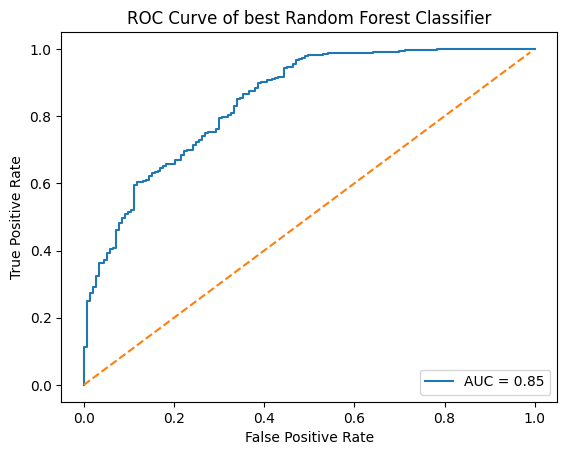

In [98]:
RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc).plot()
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--')
plt.title('ROC Curve of best Random Forest Classifier')
plt.show()

# **`ROC AUC Curve (Boosting Algorithmm - XGBoost)`**: The area under curve of ROC curve of the best XGBoost classifier is coming out be 0.88 which is pretty good and 2% higher than that of best Random Forest Classifier.

In [99]:
y_test_pred_proba = best_xgb_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thrersholds = roc_curve(y_test, y_test_pred_proba)

In [100]:
 roc_auc = roc_auc_score(y_test, y_test_pred_proba)

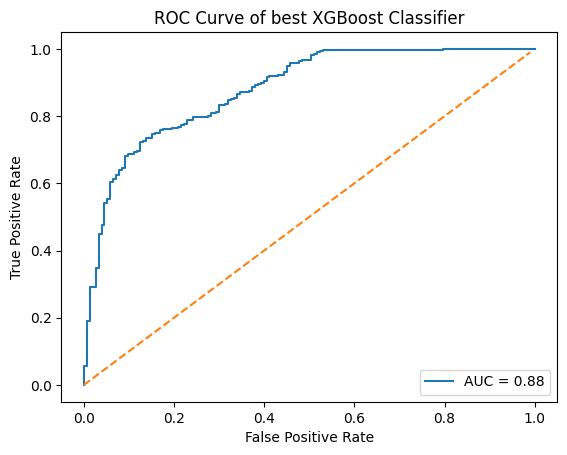

In [101]:
RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc).plot()
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--')
plt.title('ROC Curve of best XGBoost Classifier')
plt.show()

***

# **`Confusion Matrix (Bagging Algorithmm - Random Forest):`**
### As we can clearly notice from the confusion matrix (shown below), out of 324 drivers leaving Ola, our model has identified 292 of them (i.e. `Recall = 292/324 = 90%`) and out of 353 drivers which our model has identified as leaving, 292 are actually leaving (i.e. `Precision = 292/353 = 83%`)

In [102]:
y_test_pred = best_rf_clf.predict(X_test)

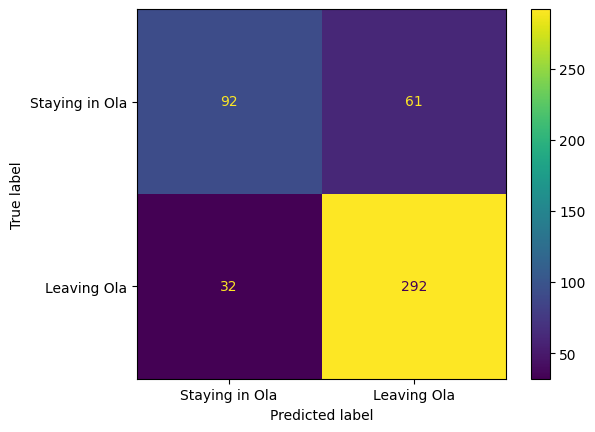

In [103]:
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=['Staying in Ola', 'Leaving Ola']).plot()
plt.show()

In [113]:
310/(380)

0.8157894736842105

# **`Confusion Matrix (Boosting Algorithmm - XGBoost):`**
### As we can clearly notice from the confusion matrix (shown below), out of 324 drivers leaving Ola, our model has identified 307 of them (i.e. `Recall = 310/324 = 95.6%`) and out of 380 drivers which our model has identified as leaving, 310 are actually leaving (i.e. `Precision = 310/380 = 81.5%`). The recall of Boosting Algorithm is 5% higher than that of Bagging Algorithm.

In [104]:
y_test_pred = best_xgb_clf.predict(X_test)

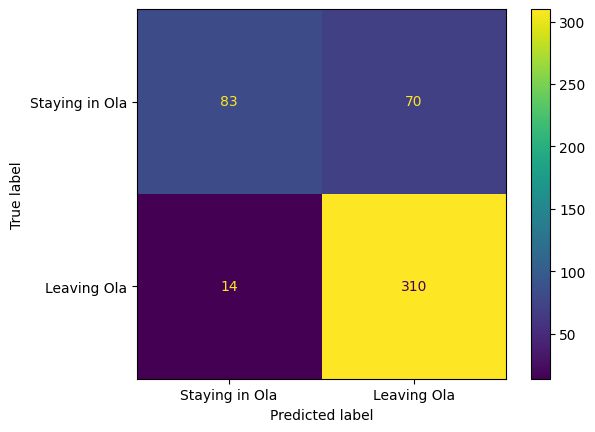

In [105]:
cm = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm, display_labels=['Staying in Ola', 'Leaving Ola']).plot()
plt.show()

***

# **`Classification Report (Bagging Algorithmm - Random Forest)`**:
### The classification report (shown below) shows that for positive class (i.e. drivers leaving Ola), `Recall = 0.90` & `Precision = 0.83` which is great. Whereas for the negative class (i.e. drivers not leaving Ola), `Recall = 0.60` & `Precision = 0.74` which is descent because we have tuned our model to have a high recall on positive class so as to identify maximum number of drivers who are about to leave Ola.

In [106]:
y_test_pred = best_rf_clf.predict(X_test)

In [107]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.74      0.60      0.66       153
           1       0.83      0.90      0.86       324

    accuracy                           0.81       477
   macro avg       0.78      0.75      0.76       477
weighted avg       0.80      0.81      0.80       477



# **`Classification Report (Boosting Algorithmm - XGBoost)`**:
### The classification report (shown below) shows that for positive class (i.e. drivers leaving Ola), `Recall = 0.96` & `Precision = 0.82` which is pretty great. Whereas for the negative class (i.e. drivers not leaving Ola), `Recall = 0.54` & `Precision = 0.86` which is descent because we have tuned our model to have a high recall on positive class so as to identify maximum number of drivers who are about to leave Ola. So for positive class, Boosting algorithm is giving better results than Bagging Algorithm.

In [108]:
y_test_pred = best_xgb_clf.predict(X_test)

In [109]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.54      0.66       153
           1       0.82      0.96      0.88       324

    accuracy                           0.82       477
   macro avg       0.84      0.75      0.77       477
weighted avg       0.83      0.82      0.81       477



***

In [183]:
df_train = pd.concat((X_train, y_train), axis = 1)
df_test = pd.concat((X_test, y_test), axis = 1)
merged_df = pd.concat((df_train, df_test), axis = 0)
merged_df.rename(columns = {'Target': 'left'}, inplace = True)

merged_df['months_active_cat'] = merged_df['Months_Active'].apply(lambda x: '1-6 months' if 1 <= x <= 6
                                                                  else '7-12 months' if 7 <= x <= 12
                                                                  else '13-18 months' if 13 <= x <= 18
                                                                  else '19-24 months' if 19 <= x <= 24
                                                                  else '>24 months')

merged_df['mean_quarterly_rating_cat'] = merged_df['Mean_Quarterly_Rating'].apply(lambda x: '1-2' if 1 <= x < 2
                                                                  else '2-3' if 2 <= x < 3
                                                                  else '3-4')

min_bus_val = merged_df['Total_Business_Value'].min()
bus_val_p25, bus_val_p50, bus_val_p75 = np.percentile(merged_df['Total_Business_Value'], [25, 50, 75])
max_bus_val = merged_df['Total_Business_Value'].max()
merged_df['Total_Business_Value_cat'] = merged_df['Total_Business_Value'].apply(lambda x: 'Very Low' if min_bus_val <= x < bus_val_p25
                                                                                else 'Low' if bus_val_p25 <= x < bus_val_p50
                                                                                else 'Medium' if bus_val_p50 <= x < bus_val_p75
                                                                                else 'High')

min_mean_income = merged_df['mean_income'].min()
mean_income_p25, mean_income_p50, mean_income_p75 = np.percentile(merged_df['mean_income'], [25, 50, 75])
max_mean_income = merged_df['mean_income'].max()
merged_df['mean_income_cat'] = merged_df['mean_income'].apply(lambda x: 'Very Low' if min_mean_income <= x < mean_income_p25
                                                              else 'Low' if mean_income_p25 <= x < mean_income_p50
                                                              else 'Medium' if mean_income_p50 <= x < mean_income_p75
                                                              else 'High')

In [184]:
desc_order_feature_importance = np.argsort(best_xgb_clf.feature_importances_)[::-1]
highest_feature_importance = np.sort(best_xgb_clf.feature_importances_)[::-1]
most_important_features = best_xgb_clf.feature_names_in_[desc_order_feature_importance]

## **`In the table (DataFrame) shown below, we can see the most important features in XGBoost Classifer (Boosting Algorithm) in the order od decreasing feature importance.`**

In [185]:
feature_tally = pd.DataFrame(data = [list(pair) for pair in zip(most_important_features, highest_feature_importance)], columns = ['Feature', 'Feature Importance'])
feature_tally

,Feature,Feature Importance
0,Quarterly_Rating_increased,0.192044
1,Months_Active,0.173855
2,Joining_Designation,0.138030
3,Mean_Quarterly_Rating,0.089172
4,Total_Business_Value,0.074758
5,Gender,0.055589
6,Mean_Business_Value,0.054435
7,City,0.051489
8,mean_income,0.045522
9,Age,0.043729


***

# **`Actionable Insights & Recommendations:`**

### **`1. Quarterly Rating Increased:`** **"Quarterly_Rating_increased"** is most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.192044**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers whose Quarterly Rating is not increased, the attrition rate (\~80%) is much higher than that of drivers whose Quarterly Rating has increased (\~42%).
### **`Recommendation:`** We would recommend the management team of Ola to give out some incentive to those drivers who are just at the verge of increased Quarterly Rating to motivate them and eventually stay at Ola.

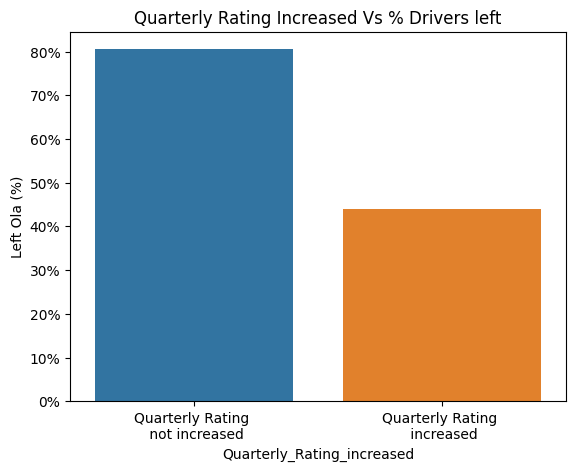

In [188]:
qrtly_rating_increased_vs_left = merged_df.groupby('Quarterly_Rating_increased')['left'].mean().to_frame().reset_index()

sns.barplot(x = qrtly_rating_increased_vs_left['Quarterly_Rating_increased'], y = qrtly_rating_increased_vs_left['left'] * 100)
plt.xticks(ticks = [0, 1], labels = ['Quarterly Rating \n not increased', 'Quarterly Rating \n increased'])
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [str(i) + '%' for i in range(0, 90, 10)])
plt.title('Quarterly Rating Increased Vs % Drivers left')
plt.show()

### **`2. Months Active:`** **"Months Active"** is the second most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.173855**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers who have low `"Months Active (i.e. new at Ola)"`, the attrition rate is much higher than that of drivers who have high `"Months Active (i.e. been at Ola for a long time)"`
### **`Recommendation:`** We would recommend Ola to set some milestonbes for drivers' tenure at Ola and give away some awards or rewards to those drivers who achieve milestone of staying at Ola so that they feel like an asset to the organization.

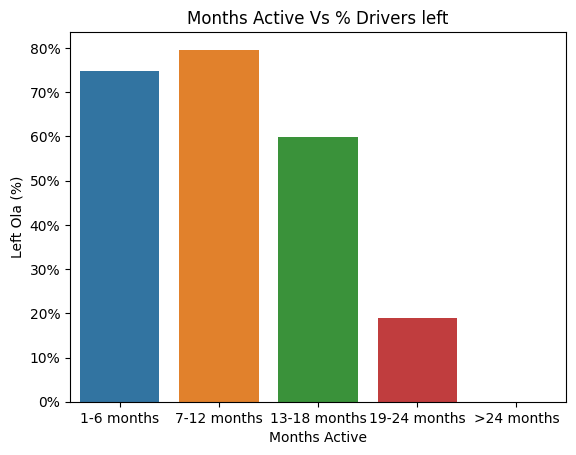

In [152]:
months_active_vs_left = merged_df.groupby('months_active_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = months_active_vs_left['months_active_cat'], y = months_active_vs_left['left'] * 100, order = ['1-6 months', '7-12 months',
                                                                                                              '13-18 months', '19-24 months',
                                                                                                              '>24 months'])
plt.xlabel('Months Active')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [str(i) + '%' for i in range(0, 90, 10)])
plt.title('Months Active Vs % Drivers left')
plt.show()

### **`3. Joining Designation:`** **"Joining_Designation"** is the third most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.138030**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers who join at very low designation tend to leave the most because they would've been feeling dissatisfied with the designation they got. For the drivers who have mediocre joining designation, the attrition rate is low but as we move towards the high joining designation, the attrition rate rises again because they may be feeling like they deserve better.

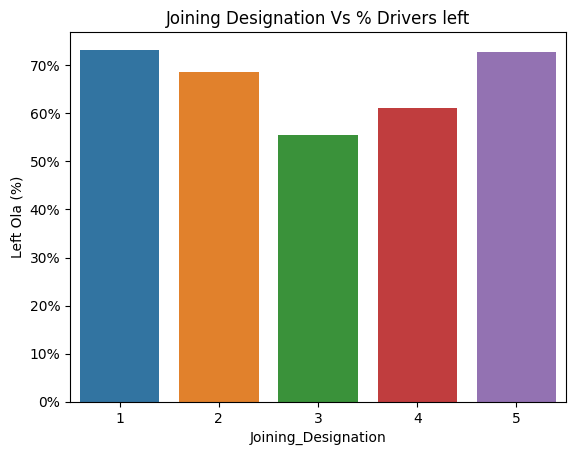

In [155]:
joining_designation_vs_left = merged_df.groupby('Joining_Designation')['left'].mean().to_frame().reset_index()

sns.barplot(x = joining_designation_vs_left['Joining_Designation'], y = joining_designation_vs_left['left'] * 100)
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 80, 10), labels = [str(i) + '%' for i in range(0, 80, 10)])
plt.title('Joining Designation Vs % Drivers left')
plt.show()

### **`4. Mean Quarterly Rating:`** **"Mean Quarterly Rating"** is the fourth most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.089172**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers who have low `"Mean Quarterly Rating"`, the attrition rate is much higher than that of drivers who have high `"Mean Quarterly Rating"`
### **`Recommendation:`** We would recommend Ola to run some campaigns to motivate the drivers who have low Mean Quarterly Rating and set some milestones for drivers and give away some awards or rewards to those drivers who achieve those milestones. This way, we can keep them motivated and make them stay at Ola.

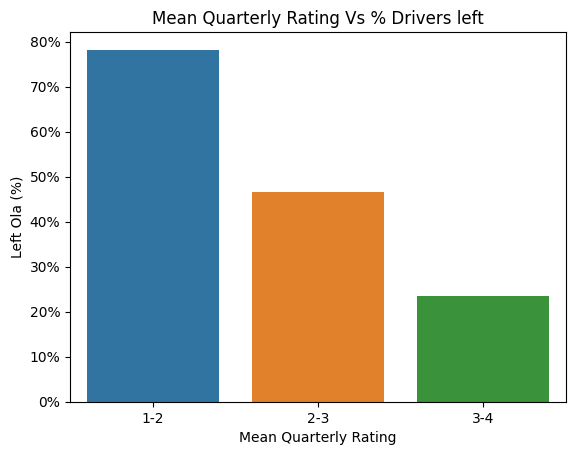

In [166]:
mean_quarterly_rating_vs_left = merged_df.groupby('mean_quarterly_rating_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = mean_quarterly_rating_vs_left['mean_quarterly_rating_cat'], y = mean_quarterly_rating_vs_left['left'] * 100, order = ['1-2', '2-3', '3-4'])
plt.xlabel('Mean Quarterly Rating')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [str(i) + '%' for i in range(0, 90, 10)])
plt.title('Mean Quarterly Rating Vs % Drivers left')
plt.show()

### **`5. Total Business Value:`** **"Total Business Value"** is the fifth most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.074758**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers who have very low `"Total Business Value"`, the attrition rate (\~100%) is much higher than that of drivers who have high `"Total Business Value"` (\~40%).
### **`Recommendation:`** We would recommend Ola to run some campaigns to motivate the drivers who have low Total Business Value and give away some incentives to those drivers who are just about to leave. This way, we can keep them motivated and make them stay at Ola.

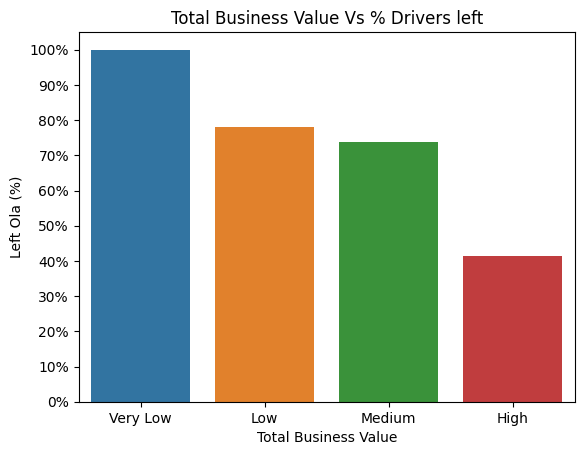

In [172]:
total_business_value_vs_left = merged_df.groupby('Total_Business_Value_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = total_business_value_vs_left['Total_Business_Value_cat'], y = total_business_value_vs_left['left'] * 100, order = ['Very Low', 'Low',
                                                                                                                                   'Medium', 'High'])
plt.xlabel('Total Business Value')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 110, 10), labels = [str(i) + '%' for i in range(0, 110, 10)])
plt.title('Total Business Value Vs % Drivers left')
plt.show()

### **`6. Mean Income:`** **"Mean Income"** is the sixth most important (significant) feature in our XGBoost Classifier (Boosting Algorithm) with **normalized feature importance = 0.055589**. We can also see this from the bar plot shown below.
### **`Insight:`** For the drivers who have very low `"Mean Income"`, the attrition rate (\~80%) is much higher than that of drivers who have high `"Mean Income"` (\~55%).
### **`Recommendation:`** We would recommend Ola to run some campaigns to motivate the drivers who have low Mean Income and give away some incentives to those drivers who are just about to leave. This way, we can keep them motivated and make them stay at Ola.

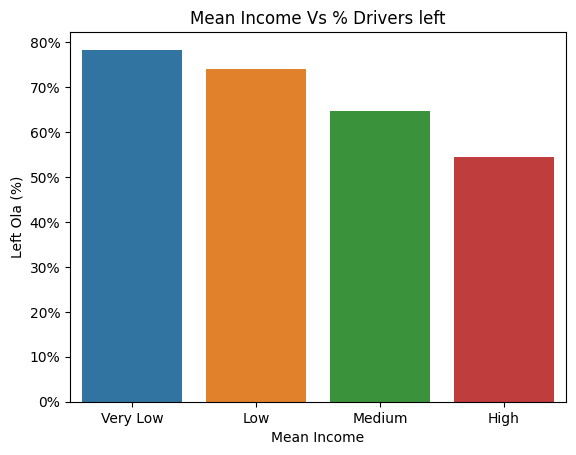

In [177]:
mean_income_vs_left = merged_df.groupby('mean_income_cat')['left'].mean().to_frame().reset_index()

sns.barplot(x = mean_income_vs_left['mean_income_cat'], y = mean_income_vs_left['left'] * 100, order = ['Very Low', 'Low', 'Medium', 'High'])
plt.xlabel('Mean Income')
plt.ylabel('Left Ola (%)')
plt.yticks(ticks = range(0, 90, 10), labels = [str(i) + '%' for i in range(0, 90, 10)])
plt.title('Mean Income Vs % Drivers left')
plt.show()